In [282]:
import os # functions for interacting with operating system 
import numpy as np # library used for numerical operations involving large arrays and matrices
import pandas as pd # library used for handling structured data like HDF5 files by providing data structures like DataFrames
import matplotlib.pyplot as plt # module used for visualizations

# Import juliacall-related modules before torch
from sxs.julia import PostNewtonian

# Import torch and related libraries after juliacall
import torch
import gpytorch #GP library buily on PyTorch
from torch.utils.data import DataLoader, TensorDataset # utility that loads data in batches; wraps tensors into objects for PyTorch
from sklearn.preprocessing import StandardScaler #standardizes features by removing the mean and scaling to unit variance (normalizes and helps models converge faster)

from scipy.optimize import curve_fit # finds best fitting parameters for the function
from scipy.stats import t #t-distribution, used for statistical tests and confidence intervals, particularly when sample size is small

### Startup
- Define functions
- Now instead of importing past BFI simulations and filtering out the ones we don't want to focus on, use the BFI PN one we just ran

In [283]:
# Define functions

# Function to normalize data using standardization formula
def normalize_data(X, Y):
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    # Reshape X and Y into 2D arrays before fitting
    X_normalized = scaler_X.fit_transform(X.reshape(-1, 1))
    Y_normalized = scaler_Y.fit_transform(Y.reshape(-1, 1))
    return X_normalized, Y_normalized, scaler_X, scaler_Y

# Function to denormalize predictions (converts them back to original scale);
# model makes predictions in standardized space, but we need the real values to interpret the results correctly
def denormalize_predictions(pred_mean, pred_stddev, scaler_Y):
    scale = scaler_Y.scale_[0]  # Extract scalar
    mean_unnormalized = scaler_Y.inverse_transform(pred_mean.reshape(-1, 1)).squeeze()
    stddev_unnormalized = scale * pred_stddev  # Scaling the stddev
    return mean_unnormalized, stddev_unnormalized

# First Model - not using this one now
# Define the GP Regression Model class
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Assumes data has a constant mean
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Use RBF kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
# Function to train the GPR model
def train_gpr_model(train_X, train_Y):

    """
    Trains a Gaussian Process Regression (GPR) model using the given training data.

    Parameters:
    - train_X (torch.Tensor): input training data (features)
    - train_Y (torch.Tensor): corresponding output training data (labels)
    
    Returns:
    - model (GPRegressionModel): trained Gaussian Process model
    - likelihood (gpytorch.likelihoods.GaussianLikelihood): likelihood function for making predictions
    """

    # Initialize the Gaussian likelihood function assuming the noise is Gaussian
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    # Create an instance of the GPRegressionModel with the training data and likelihood
    model = GPRegressionModel(train_X, train_Y, likelihood)

    # Set to training mode
    model.train()
    likelihood.train()

    # Define Adam optimizer with learning rate, which control step size/how much the model updates its parameters
    # during training (too small, may take too long; too large, may diverge; 0.01-0.1 is common for GP)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # Define the loss function; measures how well the model fits the data
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Training loop runs gradient descent for 50 iterations
    for i in range(50):
        optimizer.zero_grad() # Zero out gradients from the previous step
        output = model(train_X) # Compute the predicted distribution over outputs
        loss = -mll(output, train_Y) # Compute the loss (negative log likelihood)
        loss.backward() # Backpropagation: compute gradients of loss wrt model parameters (essentially finds direction and magnitude in which each parameter
        #should be adjusted to reduce loss)
        optimizer.step() # Update model parameters
    return model, likelihood

# Second Model - this is the one that gets used
# Modified Class to improve GPR predictions GPRegressionModel class
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        
        # Define base kernels - use both RBF and Matern kernel to allow model to handle both smooth and rougher functions (both nonlinear kernels)
        self.rbf_kernel = gpytorch.kernels.RBFKernel()
        self.matern_kernel = gpytorch.kernels.MaternKernel(nu=2.5)
        
        # Wrap each kernel with a scale kernel
        self.scaled_rbf = gpytorch.kernels.ScaleKernel(self.rbf_kernel)
        self.scaled_matern = gpytorch.kernels.ScaleKernel(self.matern_kernel)
        
        # Combine kernels and find the sum
        self.covar_module = self.scaled_rbf + self.scaled_matern
        
        # Mean function (linear mean often works better than constant mean)
        self.mean_module = gpytorch.means.LinearMean(input_size=1)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Modified training function without verbose warnings
def train_gpr_model(train_X, train_Y):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPRegressionModel(train_X, train_Y, likelihood)
    model.train()
    likelihood.train()
    # Use Adam optimizer with better learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    # Add learning rate scheduler without verbose flag (reduces learning rate dynamically if loss doesn't improve for the "patience" cycles)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.5, # Reduce LR by a factor of 0.5 when triggered
        patience=5 # Wait 5 epochs before reducing LR if there is no improvement
    )

    # Define the loss function
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    # Training loop
    # Track the best model to prevent overfitting
    best_loss = float('inf') # Initialize best loss as infinity
    best_state = None # Placeholder for best model state
    # Training loop for 200 iterations
    for i in range(200):
        # Ensure model is in training mode at start of each iteration
        model.train()
        likelihood.train()
        # Reset gradients from previous iteration
        optimizer.zero_grad()
        # Compute model output
        output = model(train_X)
        # Compute negative log-likelihood loss
        loss = -mll(output, train_Y)
        # Backpropagation: compute gradients of loss wrt model parameters
        loss.backward()
        # Update model parameters
        optimizer.step()
        # Update and adjust learning rate
        scheduler.step(loss)
        # Save best model parameters (if current loss is the lowest)
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_state = model.state_dict().copy()
    # Load best model state after training
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, likelihood


# High Order PostNewtonian Initial values
def omega_and_adot(r, q, chiA, chiB):

    """
    Calculate the orbital frequency and normalized rate of change of separation for a binary black hole system.

    Parameters:
    - r (float): The separation between the two black holes.
    - q (float): The mass ratio of the two black holes, defined as M1/M2.
    - chiA (array-like): The dimensionless spin vector [chiA_x, chiA_y, chiA_z] of the first black hole.
    - chiB (array-like): The dimensionless spin vector [chiB_x, chiB_y, chiB_z] of the second black hole.

    Returns:
    - Omega (float): The orbital frequency of the binary system.
    - adot (float): The rate of change of separation normalized by the separation, i.e., separation_dot / r.
    
    This function uses the post-Newtonian approximation to model the dynamics of a binary black hole system.
    It initializes the system with the given parameters and computes the orbital frequency and separation rate.
    """

    pn = PostNewtonian.BBH(
        np.array(
            [q / (1.0 + q), 1.0 / (1.0 + q), *chiA, *chiB, 1, 0, 0, 0, 1, 0]
        )
    )
    pn.state[12] = PostNewtonian.separation_inverse(r, pn)
    return PostNewtonian.Omega(pn), PostNewtonian.separation_dot(pn) / r

# PostNewtonian Initial values - this is the one that's being used
def omega_and_adot(r, q, chiA, chiB):

    """
    Calculate the orbital frequency and normalized rate of change of separation for a binary black hole system.

    Parameters:
    - r (float): The separation between the two black holes.
    - q (float): The mass ratio of the two black holes, defined as M1/M2.
    - chiA (array-like): The dimensionless spin vector [chiA_x, chiA_y, chiA_z] of the first black hole.
    - chiB (array-like): The dimensionless spin vector [chiB_x, chiB_y, chiB_z] of the second black hole.

    Returns:
    - Omega (float): The orbital frequency of the binary system.
    - adot (float): The rate of change of separation normalized by the separation, i.e., separation_dot / r.
    """

    # Ensure chiA and chiB are lists or arrays of length 3
    assert len(chiA) == 3, "chiA must have 3 elements"
    assert len(chiB) == 3, "chiB must have 3 elements"

    # Construct the state array with 14 elements - 2 for mass fractions, 6 for spins, 6 for initial conditions
    state = np.array([
        q / (1.0 + q),
        1.0 / (1.0 + q),
        *chiA,
        *chiB,
        1, 0, 0, 0, 1, 0
    ])

    # Ensure the state array has the correct length
    assert len(state) == 14, "State array must have 14 elements"

    # Initialize the post-Newtonian system
    pn = PostNewtonian.BBH(state)
    pn.state[12] = PostNewtonian.separation_inverse(r, pn)
    return PostNewtonian.Omega(pn), PostNewtonian.separation_dot(pn) / r # Return orbital frequency and normalized separation rate

# Function to compute initial PN values (plot to compare to higher order PN guesses)
# Compute additional PN terms explicitly instead of relying on PostNewtonian.BBH
def omegaAndAdot(r, q, chiA, chiB, rPrime0):
    # Ensure chiA and chiB are numpy arrays
    chiA = np.array(chiA)
    chiB = np.array(chiB)
    
    LHat = np.array([0., 0., 1.]) # Defines the direction of the orbital angular momentum
    chiAL = np.dot(chiA, LHat) # Projections of spin vectors onto the angular momentum
    chiBL = np.dot(chiB, LHat) # Projections of spin vectors onto the angular momentum
    chiAB = np.dot(chiA, chiB)
    rInv = 1. / r # Reciprocal of separation, used for PN expansions
    # Mass related quantities
    mA = q / (1. + q)
    mB = 1. / (1. + q)
    eta = mA * mB
    deltaM = mA - mB
    # Linear and mass difference weighted spin projections
    SL = np.dot(LHat, mA**2. * chiA + mB**2. * chiB)
    SigmaL = np.dot(LHat, mB * chiB - mA * chiA)

    # Post-Newtonian terms
    # See equation 4.2 of http://arxiv.org/abs/1212.5520v1 for the PN expression for omega(r) for circular orbits.
    # Note that the 2.5PN term disagrees with equation 5.10, 5.11a, 5.11b of http://journals.aps.org/prd/pdf/10.1103/PhysRevD.74.104033
    # We use the version in equation 4.2 of the first reference since it is more recent.
    # We also include the spin-spin term (2PN order) from equation 4.5 of Equation 4.5 of http://arxiv.org/abs/gr-qc/9506022
    # Equation 228 of http://arxiv.org/abs/1310.1528 also gives omega(r), without spin terms.
    A1 = (-3. + eta) * rInv
    A1p5 = (-chiAL * (2. * mA**2. + 3. * eta) - chiBL * (2. * mB**2. + 3. * eta)) * rInv * np.sqrt(rInv)
    A2 = (6. + 41 * eta / 4. + eta**2 - 1.5 * eta * chiAB + 4.5 * eta * chiAL * chiBL) * rInv * rInv
    A2p5 = ((22.5 - 13.5 * eta) * SL + (13.5 - 6.5 * eta) * deltaM * SigmaL) * (rInv**2.5)
    A3 = (-10. + (-75707./840 + 41 * np.pi**2 / 64. + 22. * np.log(r / rPrime0)) * eta + 9.5 * eta**2 + eta**3.) * rInv * rInv * rInv
    A3p5 = (1./8.) * ((-495. - 561. * eta - 51 * eta**2) * SL + (-297. - 341 * eta - 21 * eta**2) * deltaM * SigmaL) * (rInv**3.5)
    omega = np.sqrt(rInv**3. * (1. + A1 + A1p5 + A2 + A2p5 + A3 + A3p5))

    # adot
    # adot0 = (dr/dt)/r, given in equation 4.12 of
    # http://arxiv.org/abs/gr-qc/9506022
    B1 = -(1./336.) * (1751 + 588 * eta) * rInv
    B1p5 = -((7./12.) * (chiAL * (19. * mA**2. + 15. * eta) + chiBL * (19. * mB**2. + 15. * eta)) - 4. * np.pi) * rInv * np.sqrt(rInv)
    B2 = (-5./48.) * eta * (59. * chiAB - 173. * chiAL * chiBL) * rInv * rInv

    dr_dt = (-64./5.) * eta * rInv * rInv * rInv * (1 + B1 + B1p5 + B2)
    adot = dr_dt / r

    return omega, adot

def polynomial_fit_with_confidence(X, y, degree, confidence_level=0.95, initial_guess=None):
    """
    Fits a polynomial model to the data and calculates the confidence bands.

    Parameters:
    X (array-like): Independent variable data.
    y (array-like): Dependent variable data.
    degree (int): Degree of the polynomial to fit.
    confidence_level (float): Confidence level for prediction interval.
    initial_guess (array-like, optional): Initial guess for polynomial coefficients.

    Returns:
    params (array): Fitted parameters of the polynomial.
    x_fit (array): X values for the fit line.
    y_fit (array): Y values of the fitted polynomial.
    y_lower (array): Lower bound of the confidence interval.
    y_upper (array): Upper bound of the confidence interval.
    """

    def model_poly(x, *params):
        return sum(p * x**i for i, p in enumerate(params))

    # Use default initial guesses if none are provided
    if initial_guess is None:
        initial_guess = np.ones(degree + 1)

    # Fit the model to the data
    params, covariance = curve_fit(model_poly, X, y, p0=initial_guess)

    # Generate model predictions for plotting
    x_fit = np.linspace(min(X), max(X), 100)
    y_fit = model_poly(x_fit, *params)

    # Calculate the residuals - difference between actual output and predicted values
    residuals = y - model_poly(X, *params)

    # Degrees of freedom - number of data points minus number of fitted parameters
    dof = len(X) - len(params)  # Degrees of freedom

    # Estimate the variance of the residuals - how much the data deviates from the fitted curve
    var_res = np.var(residuals, ddof=len(params))

    # Calculate the standard error of the fitted values with Jacobian Matrix
    J = np.vstack([x_fit**i for i in range(len(params))]).T
    se_y_fit = np.sqrt(np.diag(J @ covariance @ J.T) + var_res)

    # Calculate the prediction interval by computing the t-score for the confidence interval
    t_val = t.ppf((1 + confidence_level) / 2., dof)
    y_upper = y_fit + t_val * se_y_fit
    y_lower = y_fit - t_val * se_y_fit

    return params, x_fit, y_fit, y_lower, y_upper

In [284]:
# Example parameters for Post-Newtonian approximation
r = 10.0  # Separation between the black holes in some units
q = 1.0   # Mass ratio (M1/M2)
chiA = [0,0,0]  # Dimensionless spin vector for the first black hole
chiB = [0,0,0]  # Dimensionless spin vector for the second black hole

# Calculate the orbital frequency and rate of change of separation
omega, adot = omega_and_adot(r, q, chiA, chiB)

# Print the results
print(f"Orbital Frequency (Omega): {omega}")
print(f"Rate of Change of Separation (adot): {adot}")

Orbital Frequency (Omega): 0.028089352675245916
Rate of Change of Separation (adot): -0.000281044845893221


In [285]:
# # Reading the HDF5 file
# try:
#     df = pd.read_hdf("filtered_simulations_2.h5", key="filtered_data")
#     print("DataFrame successfully read from HDF5!")
# except Exception as e:
#     print(f"Error reading DataFrame from HDF5: {e}")

# # Display the DataFrame
# # print(df.head())

Can do separate fits: omega(D) and adot(D). This model predicts the values of omega and adot that give ecc=0 for every D. calls omega0 because that corresponds to the set ecc=0

In [286]:
# # Extract column names
# columns = df.columns.tolist()
# columns_df = pd.DataFrame(columns, columns=["Column Names"])
# print(columns_df)

Omega and adot from BFI PN sims we ran - April 2025

should probably import them from BFI as HDF5 file like before - can fix later

In [287]:
import pandas as pd

# Create the PN final results DataFrame
data_omega_adot = pd.DataFrame({
    'spec_id': ['005', '009', '010', '006', '011', '012', '007', '013', '014', '015', '016', '008'],
    'initial_separation': [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
    'initial_orbital_frequency_PN': [2.4622e-2, 2.1782e-2, 1.9452e-2, 1.7510e-2,
                                  1.5874e-2, 1.4476e-2, 1.3272e-2, 1.2227e-2,
                                  1.1312e-2, 1.0506e-2, 9.7912e-3, 9.1539e-3],
    'initial_adot_PN': [-1.5778e-4, -9.8886e-5, -6.8872e-5, -5.2887e-5,
                     -4.1326e-5, -3.0547e-5, -2.3394e-5, -1.8034e-5,
                     -1.3274e-5, -1.02169e-5, -7.9184e-6, -6.2472e-6]
})

data_omega_adot.reset_index(drop=True, inplace=True)

# Show the DataFrame
display(data_omega_adot.style.hide(axis="index"))

spec_id,initial_separation,initial_orbital_frequency_PN,initial_adot_PN
005,11,0.024622,-0.000158
009,12,0.021782,-0.000099
010,13,0.019452,-0.000069
006,14,0.017510,-0.000053
011,15,0.015874,-0.000041
012,16,0.014476,-0.000031
007,17,0.013272,-0.000023
013,18,0.012227,-0.000018
014,19,0.011312,-0.000013
015,20,0.010506,-0.000010


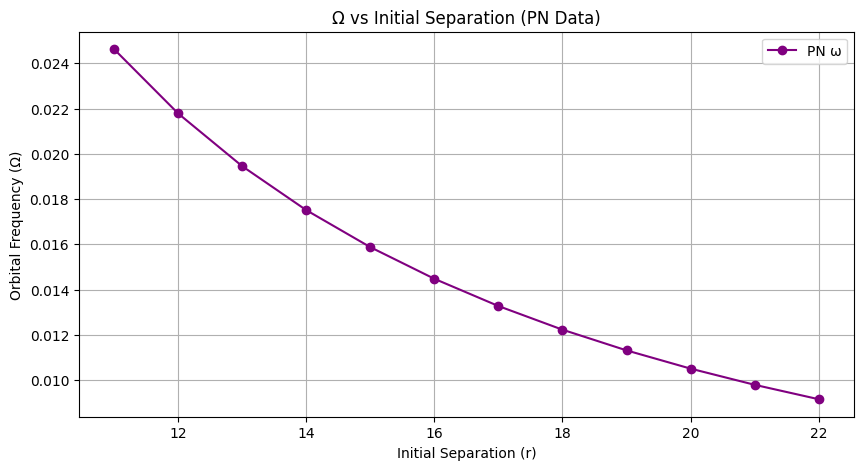

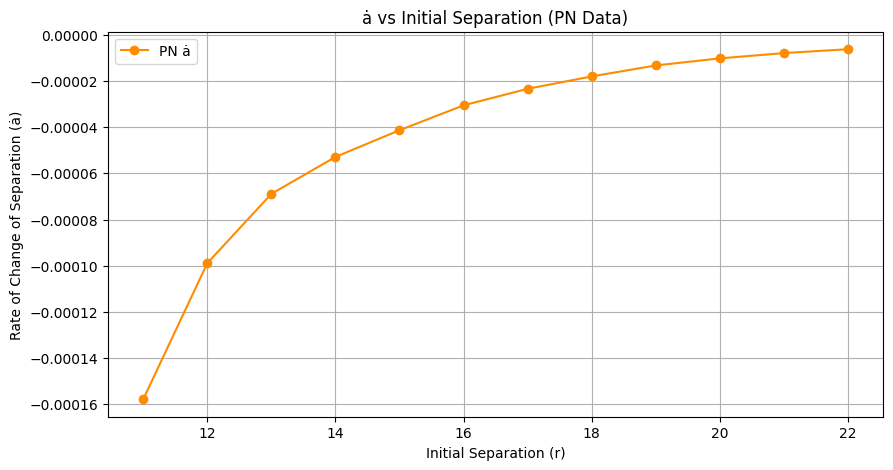

In [288]:
# Sort by initial separation - should already be done anyway
data_omega_adot = data_omega_adot.sort_values(by='initial_separation')

# Plot omega vs separation
plt.figure(figsize=(10, 5))
plt.plot(data_omega_adot['initial_separation'], data_omega_adot['initial_orbital_frequency_PN'], 'o-', color='purple', label='PN ω')
plt.xlabel('Initial Separation (r)')
plt.ylabel('Orbital Frequency (Ω)')
plt.title('Ω vs Initial Separation (PN Data)')
plt.grid(True)
plt.legend()
plt.show()

# Plot adot vs separation
plt.figure(figsize=(10, 5))
plt.plot(data_omega_adot["initial_separation"], data_omega_adot["initial_adot_PN"], 'o-', color='darkorange', label='PN ȧ')
plt.xlabel('Initial Separation (r)')
plt.ylabel('Rate of Change of Separation (ȧ)')
plt.title('ȧ vs Initial Separation (PN Data)')
plt.grid(True)
plt.legend()
plt.show()

Print to see what range of separations df_omega_adot is using (should only be between 11 and 22)

In [300]:
print(data_omega_adot["initial_separation"].min(), data_omega_adot["initial_separation"].max())

11 22


### Training using PyTorch

Define input and output Variables: 
separate fits: omega(D) and  adot(D). 
This model predicts the values of omega that result in ecc=0 for each D.

Train for omega using PN values as training data

/Users/vittoria/GitHub/spectre/env/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


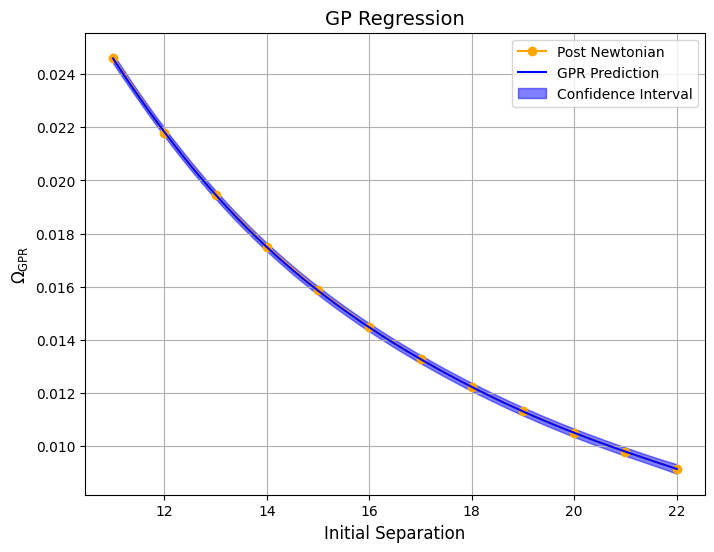

In [301]:
# Use PN data
inputVar_omega = "initial_separation"
outputVar_omega = "initial_orbital_frequency_PN"
X_omega = data_omega_adot[inputVar_omega].values
Y_omega = data_omega_adot[outputVar_omega].values

# Normalize input and output
X_normalized_omega, Y_normalized_omega, scaler_X_omega, scaler_Y_omega = normalize_data(X_omega, Y_omega)

# Convert to PyTorch tensors
train_X_omega = torch.from_numpy(X_normalized_omega).float()
train_Y_omega = torch.from_numpy(Y_normalized_omega).float().squeeze()

# Train the GPR model
model_omega, likelihood_omega = train_gpr_model(train_X_omega, train_Y_omega)

# Evaluation mode
model_omega.eval()
likelihood_omega.eval()

# Assuming new_X is the same as X
new_X_omega = X_omega

# Normalize the new input data using the same scaler
new_X_normalized_omega = scaler_X_omega.transform(new_X_omega.reshape(-1, 1))
new_X_tensor_omega = torch.from_numpy(new_X_normalized_omega).float()

# Make predictions
with torch.no_grad():
    observed_pred_omega = likelihood_omega(model_omega(new_X_tensor_omega))

# Sort the data for plotting
sorted_indices_omega = torch.argsort(new_X_tensor_omega[:, 0])
sorted_new_X_tensor_omega = new_X_tensor_omega[sorted_indices_omega]
sorted_mean_omega = observed_pred_omega.mean[sorted_indices_omega]
sorted_stddev_omega = observed_pred_omega.variance.sqrt()[sorted_indices_omega]  # Standard deviation

# Unnormalize the predictions and inputs
sorted_new_X_unnormalized_omega = scaler_X_omega.inverse_transform(sorted_new_X_tensor_omega.numpy()).ravel()
sorted_mean_unnormalized_omega, sorted_stddev_unnormalized_omega = denormalize_predictions(
    sorted_mean_omega.numpy(), sorted_stddev_omega.numpy(), scaler_Y_omega
)

# # Plot the results
# with torch.no_grad():
#     f, ax = plt.subplots(1, 1, figsize=(8, 6))
#     # Plot observed data
#     ax.plot(new_X_omega, Y_omega, 'k*', label='Observed Data')
#     # Plot mean prediction
#     ax.plot(sorted_new_X_unnormalized_omega, sorted_mean_unnormalized_omega, 'b', label='Mean Prediction')
#     # Plot confidence interval (mean ± 2 * stddev)
#     ax.fill_between(sorted_new_X_unnormalized_omega,
#                     sorted_mean_unnormalized_omega - 2 * sorted_stddev_unnormalized_omega,
#                     sorted_mean_unnormalized_omega + 2 * sorted_stddev_unnormalized_omega,
#                     alpha=0.5, color='blue', label='Confidence Interval')
#     # Add labels to the axes
#     ax.set_xlabel(inputVar_omega, fontsize=12)
#     ax.set_ylabel(outputVar_omega, fontsize=12)
#     # Add a title to the plot
#     ax.set_title('GP Regression with Confidence Interval', fontsize=14)
#     ax.legend()
#     plt.show()

# Smoothing: Generate a Dense Range of Inputs for Predictions
dense_X_omega = np.linspace(new_X_omega.min(), new_X_omega.max(), 1000).reshape(-1, 1)  # 1000 points for smoothness
dense_X_normalized_omega = scaler_X_omega.transform(dense_X_omega)

dense_X_tensor_omega = torch.from_numpy(dense_X_normalized_omega).float()

# Make predictions for the dense range
with torch.no_grad():
    dense_observed_pred_omega = likelihood_omega(model_omega(dense_X_tensor_omega))

# Unnormalize the predictions
dense_pred_mean_omega = dense_observed_pred_omega.mean.numpy()
dense_pred_stddev_omega = dense_observed_pred_omega.variance.sqrt().numpy()  # Standard deviation

dense_pred_mean_unnormalized_omega, dense_pred_stddev_unnormalized_omega = denormalize_predictions(
    dense_pred_mean_omega, dense_pred_stddev_omega, scaler_Y_omega
)

# Plot the results for the dense range
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Plot the original training data
    ax.plot(new_X_omega, Y_omega, 'o-', label='Post Newtonian', color = 'orange')

    # Plot the mean prediction for the dense range
    ax.plot(dense_X_omega, dense_pred_mean_unnormalized_omega, 'b', label='GPR Prediction')

    # Plot confidence interval (mean ± 2 * stddev)
    ax.fill_between(dense_X_omega.ravel(),
                dense_pred_mean_unnormalized_omega - 2 * dense_pred_stddev_unnormalized_omega,
                dense_pred_mean_unnormalized_omega + 2 * dense_pred_stddev_unnormalized_omega,
                alpha=0.5, color='blue', label='Confidence Interval')

    # Add labels to the axes
    ax.set_xlabel('Initial Separation', fontsize=12)
    ax.set_ylabel('$\Omega_{\mathrm{GPR}}$', fontsize=12)
    # Add a title to the plot
    ax.set_title('GP Regression', fontsize=14)
    ax.grid(True)
    ax.legend()
    plt.show()

All results plotted for omega

In [291]:
# # Plot the results for the dense range
# with torch.no_grad():
#     f, ax = plt.subplots(1, 1, figsize=(8, 6))
#     # Plot the original training data
#     ax.plot(new_X_omega, Y_omega, 'k*', label='Observed Data')
#     # plot post Newtonian
#     ax.plot(data_omega_adot["initial_separation"].values, data_omega_adot['Omega'].values, 'o-', 
#         label='Post Newtonian', color='orange', alpha=0.45
#     )
#     # # plot Least Squares Polynomial fit
#     # ax.plot(x_fit, y_fit, color='red', linewidth=1, label='LSF')
#     # ax.fill_between(x_fit, y_lower, y_upper, color='red', alpha=0.25, label='LSF Confidence Interval')

#     # Plot the mean GPR prediction for the dense range
#     ax.plot(dense_X_omega, dense_pred_mean_unnormalized_omega, 'b', label='GPR Prediction')
#     # Plot GPR confidence interval (mean ± 2 * stddev)
#     ax.fill_between(dense_X_omega.ravel(),
#                     (dense_pred_mean_unnormalized_omega - 2 * dense_pred_stddev_unnormalized_omega),
#                     (dense_pred_mean_unnormalized_omega + 2 * dense_pred_stddev_unnormalized_omega),
#                     alpha=0.25, color='blue', label='GPR Confidence Interval')
#     # Add labels to the axes
#     ax.set_xlabel(inputVar_omega, fontsize=12)
#     ax.set_ylabel(outputVar_omega, fontsize=12)
#     # Add a title to the plot
#     ax.set_title('', fontsize=14)
#     ax.legend()
#     plt.show()

Compare initial PN values (omegaAndAdot) to higher order PN guesses (omega_and_adot; ie PostNewtonian.BBH from julia)

In [292]:
# rPrime0=1
# initial_pn_freq=np.array([omegaAndAdot(d, q, chiA, chiB, rPrime0)[0] for d in sorted_new_X_unnormalized_omega]) 

# # Plot the results for the dense range
# with torch.no_grad():
#     f, ax = plt.subplots(1, 1, figsize=(8, 6))
#     # Plot the original training data
#     ax.plot(new_X_omega, Y_omega, 'k*', label='Observed Data')
#     # initial ps vals
#     plt.plot(sorted_new_X_unnormalized_omega, initial_pn_freq, 'o-', label='initial PN values', color='green', alpha=0.45)
#     # plot post Newtonian
#     ax.plot(data_omega_adot["initial_separation"].values, data_omega_adot['Omega'].values, 'o-',
#         label='higher order PN guesses', color='orange', alpha=0.45
#     )

#     # Add labels to the axes
#     ax.set_xlabel(inputVar_omega, fontsize=12)
#     ax.set_ylabel(outputVar_omega, fontsize=12)
#     # Add a title to the plot
#     ax.set_title('Comparing Initial PN Values to higher order PN guesses', fontsize=14)
#     ax.legend()
#     plt.show()

Now train for adot using PN values

/Users/vittoria/GitHub/spectre/env/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


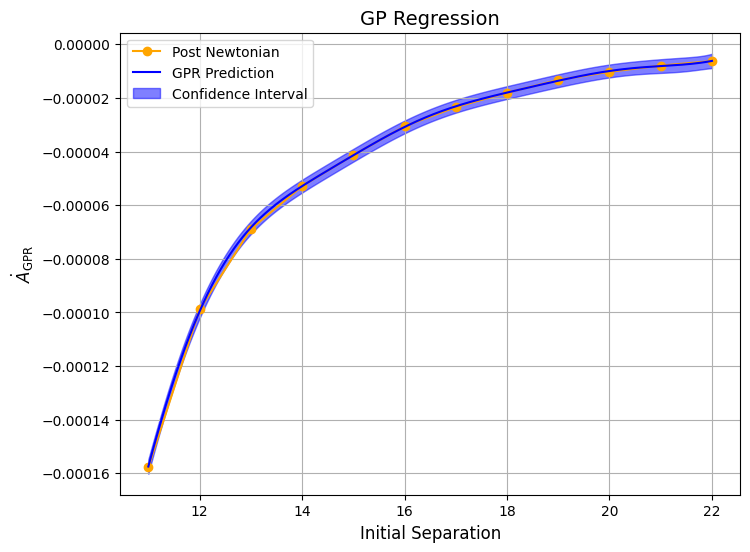

In [293]:
inputVar_adot = "initial_separation"
outputVar_adot = "initial_adot_PN"
X_adot = df_omega_adot[inputVar_adot].values
Y_adot = df_omega_adot[outputVar_adot].values

# Normalize input and output
X_normalized_adot, Y_normalized_adot, scaler_X_adot, scaler_Y_adot = normalize_data(X_adot, Y_adot)

# Convert data to PyTorch tensors
train_X_adot = torch.from_numpy(X_normalized_adot).float()
train_Y_adot = torch.from_numpy(Y_normalized_adot.ravel()).float()

# Train the GPR model
model_adot, likelihood_adot = train_gpr_model(train_X_adot, train_Y_adot)

# Switch to evaluation mode
model_adot.eval()
likelihood_adot.eval()

# Assuming new_X is the same as X
new_X_adot = X_adot

# Normalize the new input data using the same scaler
new_X_normalized_adot = scaler_X_adot.transform(new_X_adot.reshape(-1, 1))
new_X_tensor_adot = torch.from_numpy(new_X_normalized_adot).float()

# Make predictions
with torch.no_grad():
    observed_pred_adot = likelihood_adot(model_adot(new_X_tensor_adot))

# Sort the data for plotting
sorted_indices_adot = torch.argsort(new_X_tensor_adot[:, 0])
sorted_new_X_adot = new_X_tensor_adot[sorted_indices_adot]
sorted_mean_adot = observed_pred_adot.mean[sorted_indices_adot]
sorted_stddev_adot = observed_pred_adot.variance.sqrt()[sorted_indices_adot]  # Standard deviation

# Unnormalize the predictions and inputs
sorted_new_X_unnormalized_adot = scaler_X_adot.inverse_transform(sorted_new_X_adot.numpy()).ravel()
sorted_mean_unnormalized_adot, sorted_stddev_unnormalized_adot = denormalize_predictions(
    sorted_mean_adot.numpy(), sorted_stddev_adot.numpy(), scaler_Y_adot
)

# # Plot the results
# with torch.no_grad():
#     f, ax = plt.subplots(1, 1, figsize=(8, 6))
#     # Plot observed data
#     ax.plot(new_X_adot, Y_adot, 'k*', label='Observed Data')
#     # Plot mean prediction
#     ax.plot(sorted_new_X_unnormalized_adot, sorted_mean_unnormalized_adot, 'b', label='Mean Prediction')
#     # Plot confidence interval (mean ± 2 * stddev)
#     ax.fill_between(sorted_new_X_unnormalized_adot,
#                     (sorted_mean_unnormalized_adot - 2 * sorted_stddev_unnormalized_adot),
#                     (sorted_mean_unnormalized_adot + 2 * sorted_stddev_unnormalized_adot),
#                     alpha=0.5, color='blue', label='Confidence Interval')
#     # Add labels to the axes
#     ax.set_xlabel(inputVar_adot, fontsize=12)
#     ax.set_ylabel(outputVar_adot, fontsize=12)
#     # Add a title to the plot
#     ax.set_title('GP Regression with Confidence Interval (adot)', fontsize=14)
#     ax.legend()
#     plt.show()

# Smoothing: Generate a Dense Range of Inputs for Predictions
dense_X_adot = np.linspace(new_X_adot.min(), new_X_adot.max(), 1000).reshape(-1, 1)  # 1000 points for smoothness
dense_X_normalized_adot = scaler_X_adot.transform(dense_X_adot)
dense_X_tensor_adot = torch.from_numpy(dense_X_normalized_adot).float()

# Make predictions for the dense range
with torch.no_grad():
    dense_observed_pred_adot = likelihood_adot(model_adot(dense_X_tensor_adot))

# Unnormalize the predictions
dense_pred_mean_adot = dense_observed_pred_adot.mean.numpy()
dense_pred_stddev_adot = dense_observed_pred_adot.variance.sqrt().numpy()  # Standard deviation

dense_pred_mean_unnormalized_adot, dense_pred_stddev_unnormalized_adot = denormalize_predictions(
    dense_pred_mean_adot, dense_pred_stddev_adot, scaler_Y_adot
)

# Plot the results for the dense range
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Plot the original training data
    ax.plot(new_X_adot, Y_adot, 'o-', label='Post Newtonian', color = 'orange')

    # Plot the mean prediction for the dense range
    ax.plot(dense_X_adot, dense_pred_mean_unnormalized_adot, 'b', label='GPR Prediction')

    # Plot confidence interval (mean ± 2 * stddev)
    ax.fill_between(dense_X_adot.ravel(),
                    (dense_pred_mean_unnormalized_adot - 2 * dense_pred_stddev_unnormalized_adot),
                    (dense_pred_mean_unnormalized_adot + 2 * dense_pred_stddev_unnormalized_adot),
                    alpha=0.5, color='blue', label='Confidence Interval')

    # Add labels to the axes
    ax.set_xlabel('Initial Separation', fontsize=12)
    ax.set_ylabel('$\dot{A}_{\mathrm{GPR}}$', fontsize=12)
    # Add a title to the plot
    ax.set_title('GP Regression', fontsize=14)
    ax.grid(True)
    ax.legend()
    plt.show()

Compare initial PN values and higher order PN guesses for adot

In [294]:
# rPrime0=1
# initial_pn_adot=np.array([omegaAndAdot(d, q, chiA, chiB, rPrime0)[1] for d in sorted_new_X_unnormalized_adot]) 

# # Plot the results for the dense range
# with torch.no_grad():
#     f, ax = plt.subplots(1, 1, figsize=(8, 6))
#     # Plot the original training data
#     ax.plot(new_X_adot, Y_adot, 'k*', label='Observed Data')
#     # initial pn vals
#     plt.plot(sorted_new_X_unnormalized_adot, initial_pn_adot, 'o-', label='initial PN values',color='green', alpha=0.45)
#     # plot post Newtonian
#     ax.plot(data_omega_adot["initial_separation"].values, data_omega_adot['adot'].values, 'o-', label='higher order PN guesses', color='orange', alpha=0.45)

#     # Add labels to the axes
#     ax.set_xlabel(inputVar_adot, fontsize=12)
#     ax.set_ylabel(outputVar_adot, fontsize=12)
#     # Add a title to the plot
#     ax.set_title('Comparing Initial PN Values to higher order PN guesses', fontsize=14)
#     ax.legend()
#     plt.show()

In [295]:
# print(len(df["reference_dimensionless_spin1"]))
# print(len(df["reference_dimensionless_spin2"]))
# print(len(df["initial_separation"]))
# print(len(df["initial_mass_ratio"]))

### "Leave-one-out" Cross-Validation

where we train on all but one point and then predict that left-out point.
1. Loop through each data point
2. For each iteration:

    Remove one point from the training set
    Train the model on the remaining points
    Predict the value for the held-out point
    Plot the results showing:

        Training data (black stars)
        Predicted value with uncertainty (blue error bars)


In [296]:
print(df_omega_adot.columns)

Index(['spec_id', 'initial_separation', 'initial_orbital_frequency_PN',
       'initial_adot_PN'],
      dtype='object')


<Figure size 800x600 with 0 Axes>

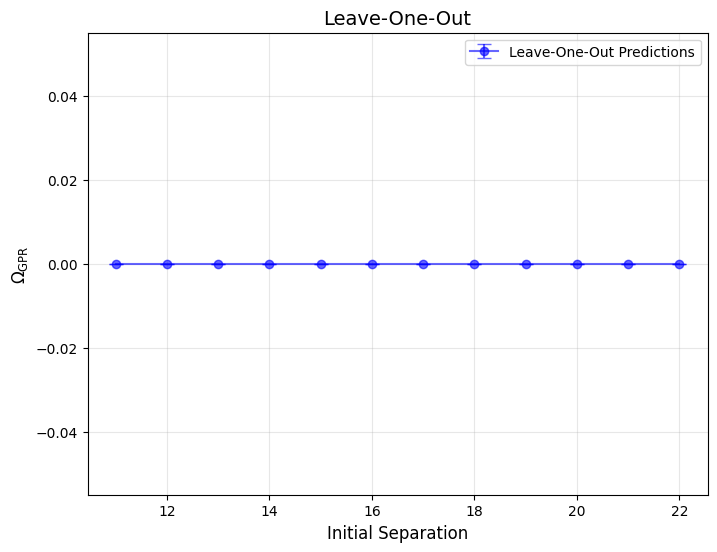

In [297]:
inputVar_omega = "initial_separation"
outputVar_omega = "initial_orbital_frequency_PN"
X_omega = df_omega_adot[inputVar_omega].values
Y_omega = df_omega_adot[outputVar_omega].values

# Arrays to store all predictions and uncertainties
all_predictions_omega = np.zeros_like(X_omega)
all_uncertainties_omega = np.zeros_like(X_omega)

# Create figure for final plot
plt.figure(figsize=(8,6))

# Loop through each point for leave-one-out predictions
for i in range(len(X_omega)):
    # Create training data excluding point i
    train_indices_omega = np.ones(len(X_omega), dtype=bool)
    train_indices_omega[i] = False

    X_train_omega = X_omega[train_indices_omega]
    Y_train_omega = Y_omega[train_indices_omega]

    # Point to predict
    X_test_omega = X_omega[i:i+1]
    Y_test_omega = Y_omega[i:i+1]

    # Normalize training and test data
    X_train_normalized_omega, Y_train_normalized_omega, scaler_X_omega, scaler_Y_omega = normalize_data(X_train_omega, Y_train_omega)
    X_test_normalized_omega = scaler_X_omega.transform(X_test_omega.reshape(-1, 1))

    # Convert to PyTorch tensors
    train_X_omega = torch.from_numpy(X_train_normalized_omega).float()
    train_Y_omega = torch.from_numpy(Y_train_normalized_omega).float().squeeze()
    test_X_omega = torch.from_numpy(X_test_normalized_omega).float()

    # Train the GPR model
    model_omega, likelihood_omega = train_gpr_model(train_X_omega, train_Y_omega)

    # Switch to evaluation mode
    model_omega.eval()
    likelihood_omega.eval()

    # Make prediction on held-out point
    with torch.no_grad():
        observed_pred_omega = likelihood_omega(model_omega(test_X_omega))

    # Get mean and standard deviation
    pred_mean_omega = observed_pred_omega.mean.numpy()
    pred_std_omega = observed_pred_omega.variance.sqrt().numpy()

    # Unnormalize predictions
    pred_mean_unnormalized_omega, pred_std_unnormalized_omega = denormalize_predictions(
        pred_mean_omega, pred_std_omega, scaler_Y_omega
    )

    # Store predictions and uncertainties (explicitly get first element)
    all_predictions_omega[i] = pred_mean_unnormalized_omega.item()
    all_uncertainties_omega[i] = pred_std_unnormalized_omega.item()

# Sort everything for clean plotting
sort_idx_omega = np.argsort(X_omega.ravel())
X_sorted_omega = X_omega[sort_idx_omega]
Y_sorted_omega = Y_omega[sort_idx_omega]
predictions_sorted_omega = all_predictions_omega[sort_idx_omega]
uncertainties_sorted_omega = all_uncertainties_omega[sort_idx_omega]

# Create final cumulative plot
plt.figure(figsize=(8,6))
# plt.plot(X_sorted_omega, Y_sorted_omega, 'k*-', label='Tested PN Values', markersize=9, alpha=0.8)

# Leave-One-Out predictions
plt.errorbar(X_sorted_omega, predictions_sorted_omega, 
             yerr=2 * uncertainties_sorted_omega, 
             fmt='bo-', label='Leave-One-Out Predictions', 
             capsize=5, alpha=0.6)

plt.xlabel('Initial Separation', fontsize=12)
plt.ylabel(r'$\Omega_{\mathrm{GPR}}$', fontsize=12)
plt.title('Leave-One-Out', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Histogram of the error for "leave one out"

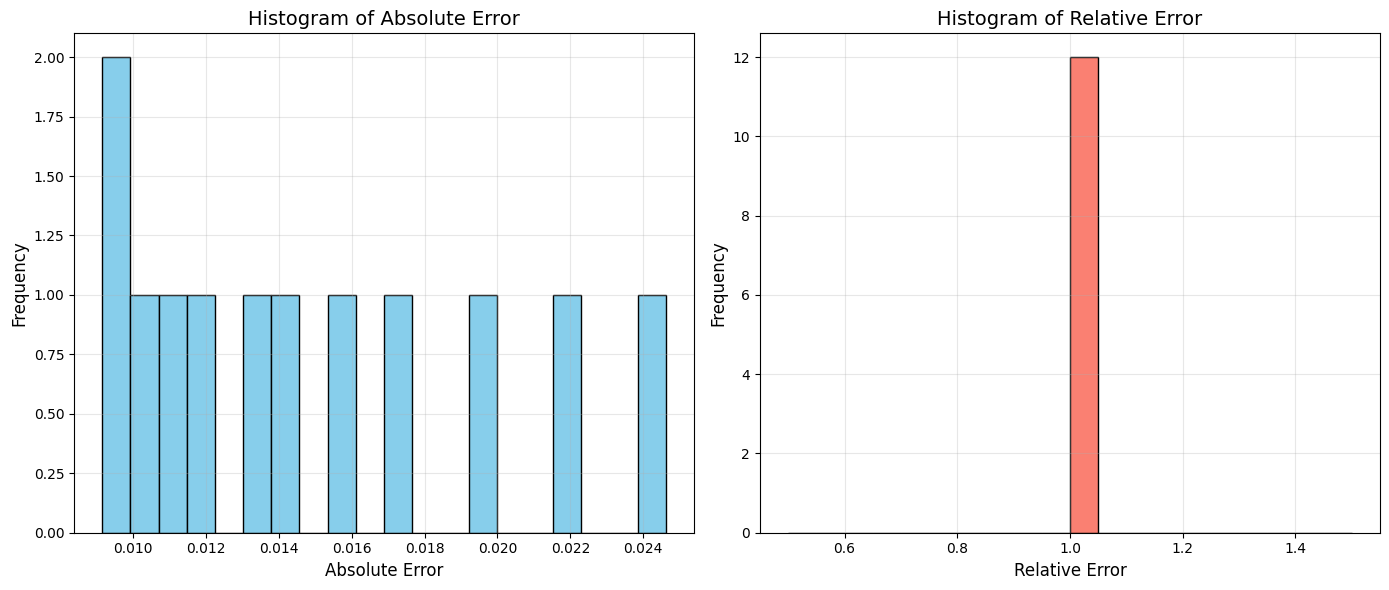

Min abs error: 0.0091539
Max abs error: 0.024622
Median abs error: 0.013874000000000001


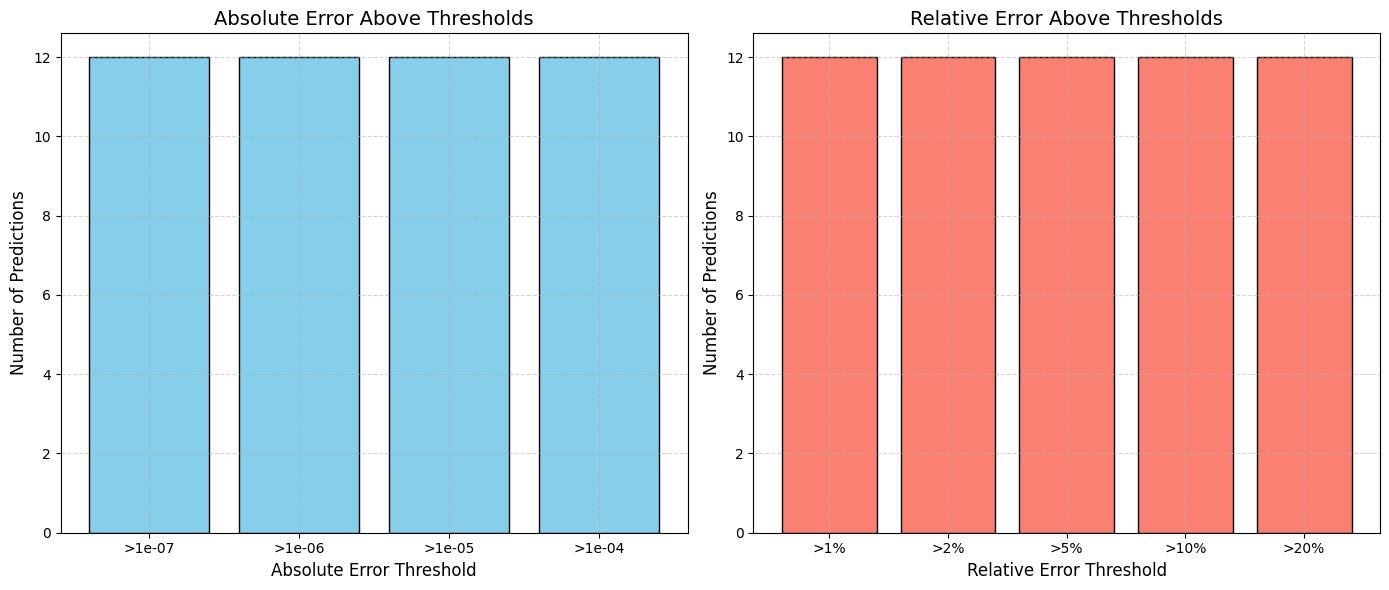

In [298]:
# Calculate absolute and relative errors
absolute_errors_omega = np.abs(all_predictions_omega - Y_omega)
relative_errors_omega = np.abs(all_predictions_omega - Y_omega) / np.abs(Y_omega)

# Create side-by-side histograms
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histogram of absolute error
axs[0].hist(absolute_errors_omega, bins=20, color='skyblue', edgecolor='black')
axs[0].set_title("Histogram of Absolute Error", fontsize=14)
axs[0].set_xlabel("Absolute Error", fontsize=12)
axs[0].set_ylabel("Frequency", fontsize=12)
axs[0].grid(True, alpha=0.3)

# Histogram of relative error
axs[1].hist(relative_errors_omega, bins=20, color='salmon', edgecolor='black')
axs[1].set_title("Histogram of Relative Error", fontsize=14)
axs[1].set_xlabel("Relative Error", fontsize=12)
axs[1].set_ylabel("Frequency", fontsize=12)
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Count predictions with errors above certain thresholds

# Check the range of absolute errors to figure out good thresholds
print("Min abs error:", absolute_errors_omega.min())
print("Max abs error:", absolute_errors_omega.max())
print("Median abs error:", np.median(absolute_errors_omega))

# Define thresholds
abs_thresholds = [1e-7, 1e-6, 1e-5, 1e-4] # raw numbers/deviation
rel_thresholds = [0.01, 0.02, 0.05, 0.1, 0.2]  # 1%, 2%; relative error is unitless - just tells us how large the error is compared
# to the true value, so plot as a percentage; tells us how wrong the prediction is relative to the size of what we are predicting

# Count how many errors are above each threshold
counts_abs_omega = [(absolute_errors_omega > t).sum() for t in abs_thresholds]
counts_rel_omega = [(relative_errors_omega > t).sum() for t in rel_thresholds]

# Create side-by-side bar plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Absolute error threshold plot
axs[0].bar([f">{t:.0e}" for t in abs_thresholds], counts_abs_omega,
           color='skyblue', edgecolor='black')
axs[0].set_title("Absolute Error Above Thresholds", fontsize=14)
axs[0].set_xlabel("Absolute Error Threshold", fontsize=12)
axs[0].set_ylabel("Number of Predictions", fontsize=12)
axs[0].grid(True, linestyle='--', alpha=0.5)

# Relative error threshold plot
axs[1].bar([f">{int(t*100)}%" for t in rel_thresholds], counts_rel_omega,
           color='salmon', edgecolor='black')
axs[1].set_title("Relative Error Above Thresholds", fontsize=14)
axs[1].set_xlabel("Relative Error Threshold", fontsize=12)
axs[1].set_ylabel("Number of Predictions", fontsize=12)
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Leave one out for adot

In [299]:
inputVar_adot = "initial_separation"
outputVar_adot = "initial_adot"
X_adot = df[inputVar_adot].values
Y_adot = df[outputVar_adot].values
# Arrays to store all predictions and uncertainties
all_predictions_adot = np.zeros_like(X_adot)
all_uncertainties_adot = np.zeros_like(X_adot)

# Create figure for final plot
plt.figure(figsize=(8,6))

# Loop through each point for leave-one-out predictions
for i in range(len(X_adot)):
    # Create training data excluding point i
    train_indices_adot = np.ones(len(X_adot), dtype=bool)
    train_indices_adot[i] = False
    
    X_train_adot = X_adot[train_indices_adot]
    Y_train_adot = Y_adot[train_indices_adot]
    
    # Point to predict
    X_test_adot = X_adot[i:i+1]
    Y_test_adot = Y_adot[i:i+1]
    
    # Normalize training and test data
    X_train_normalized_adot, Y_train_normalized_adot, scaler_X_adot, scaler_Y_adot = normalize_data(X_train_adot, Y_train_adot)
    X_test_normalized_adot = scaler_X_adot.transform(X_test_adot.reshape(-1, 1))
    
    # Convert to PyTorch tensors
    train_X_adot = torch.from_numpy(X_train_normalized_adot).float()
    train_Y_adot = torch.from_numpy(Y_train_normalized_adot).float().squeeze()
    test_X_adot = torch.from_numpy(X_test_normalized_adot).float()
    
    # Train the GPR model
    model_adot, likelihood_adot = train_gpr_model(train_X_adot, train_Y_adot)
    
    # Switch to evaluation mode
    model_adot.eval()
    likelihood_adot.eval()
    
    # Make prediction on held-out point
    with torch.no_grad():
        observed_pred_adot = likelihood_adot(model_adot(test_X_adot))
    
    # Get mean and standard deviation
    pred_mean_adot = observed_pred_adot.mean.numpy()
    pred_std_adot = observed_pred_adot.variance.sqrt().numpy()
    
    # Unnormalize predictions
    pred_mean_unnormalized_adot, pred_std_unnormalized_adot = denormalize_predictions(
        pred_mean_adot, pred_std_adot, scaler_Y_adot
    )
    
    # Store predictions and uncertainties (explicitly get first element)
    all_predictions_adot[i] = pred_mean_unnormalized_adot.item()
    all_uncertainties_adot[i] = pred_std_unnormalized_adot.item()

# Initialize arrays to store Post-Newtonian values
initial_pn_values_adot = np.zeros_like(X_adot)
higher_order_pn_values_adot = np.zeros_like(X_adot)

# Loop through each point
for i in range(len(X)):
    rPrime0 = 1  # Fixed reference value
    initial_pn_values_adot[i] = omegaAndAdot(X_adot[i], q, chiA, chiB, rPrime0)[1]  # Initial PN adot
    higher_order_pn_values_adot[i] = data_omega_adot.loc[
        data_omega_adot["initial_separation"] == X_adot[i], "adot"
    ].values[0]  # Higher order PN adot

# Sort everything for clean plotting
sort_idx_adot = np.argsort(X_adot.ravel())
X_sorted_adot = X_adot[sort_idx_adot]
Y_sorted_adot = Y_adot[sort_idx_adot]
predictions_sorted_adot = all_predictions_adot[sort_idx_adot]
uncertainties_sorted_adot = all_uncertainties_adot[sort_idx_adot]
initial_pn_sorted_adot = initial_pn_values_adot[sort_idx_adot]  # Sorted initial PN adot
higher_order_pn_sorted_adot = higher_order_pn_values_adot[sort_idx_adot]  # Sorted higher-order PN adot

# Create final cumulative plot
plt.figure(figsize=(8,6))
plt.plot(X_sorted_adot, Y_sorted_adot, 'k*', label='True Values', markersize=9, alpha=0.9)

# Leave-One-Out predictions
plt.errorbar(X_sorted_adot, predictions_sorted_adot, 
             yerr=2 * uncertainties_sorted_adot, 
             fmt='bo', label='Leave-One-Out Predictions', 
             capsize=5, alpha=0.6)

# Initial PN adot values (green)
plt.plot(X_sorted_adot, initial_pn_sorted_adot, 'o-', label='Initial PN adot', color='green', alpha=0.45)

# Higher-order PN adot guesses (orange)
plt.plot(X_sorted_adot, higher_order_pn_sorted_adot, 'o-', label='Higher-Order PN adot', color='orange', alpha=0.45)

plt.xlabel(inputVar_adot, fontsize=12)
plt.ylabel(outputVar_adot, fontsize=12)
plt.title('GPR Leave-One-Out Predictions vs. Post-Newtonian adot', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

NameError: name 'df' is not defined

In [ ]:
# Calculate absolute and relative errors
absolute_errors_adot = np.abs(all_predictions_adot - Y_adot)
relative_errors_adot = np.abs(all_predictions_adot - Y_adot) / np.abs(Y_adot)

# Create side-by-side histograms
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histogram of absolute error
axs[0].hist(absolute_errors_adot, bins=20, color='skyblue', edgecolor='black')
axs[0].set_title("Histogram of Absolute Error", fontsize=14)
axs[0].set_xlabel("Absolute Error", fontsize=12)
axs[0].set_ylabel("Frequency", fontsize=12)
axs[0].grid(True, alpha=0.3)

# Histogram of relative error
axs[1].hist(relative_errors_adot, bins=20, color='salmon', edgecolor='black')
axs[1].set_title("Histogram of Relative Error", fontsize=14)
axs[1].set_xlabel("Relative Error", fontsize=12)
axs[1].set_ylabel("Frequency", fontsize=12)
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Count predictions with errors above certain thresholds

# Check the range of absolute errors to figure out good thresholds
print("Min abs error:", absolute_errors_adot.min())
print("Max abs error:", absolute_errors_adot.max())
print("Median abs error:", np.median(absolute_errors_adot))

# Define thresholds
abs_thresholds = [1e-7, 1e-6, 1e-5, 1e-4] # raw numbers/deviation
rel_thresholds = [0.01, 0.02, 0.05, 0.1, 0.2]  # 1%, 2%; relative error is unitless - just tells us how large the error is compared
# to the true value, so plot as a percentage; tells us how wrong the prediction is relative to the size of what we are predicting

# Count how many errors are above each threshold
counts_abs_adot = [(absolute_errors_adot > t).sum() for t in abs_thresholds]
counts_rel_adot = [(relative_errors_adot > t).sum() for t in rel_thresholds]

# Create side-by-side bar plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Absolute error threshold plot
axs[0].bar([f">{t:.0e}" for t in abs_thresholds], counts_abs_adot,
           color='skyblue', edgecolor='black')
axs[0].set_title("Absolute Error Above Thresholds", fontsize=14)
axs[0].set_xlabel("Absolute Error Threshold", fontsize=12)
axs[0].set_ylabel("Number of Predictions", fontsize=12)
axs[0].grid(True, linestyle='--', alpha=0.5)

# Relative error threshold plot
axs[1].bar([f">{int(t*100)}%" for t in rel_thresholds], counts_rel_adot,
           color='salmon', edgecolor='black')
axs[1].set_title("Relative Error Above Thresholds", fontsize=14)
axs[1].set_xlabel("Relative Error Threshold", fontsize=12)
axs[1].set_ylabel("Number of Predictions", fontsize=12)
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

##### New stuff

Encapsulate normalization in GPR models: Just to allow better handling of multiple trainings (Omega and adot) to be used together at same time

In [ ]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        
        # Define base kernels - use both RBF and Matern kernel
        self.rbf_kernel = gpytorch.kernels.RBFKernel()
        self.matern_kernel = gpytorch.kernels.MaternKernel(nu=2.5)
        
        # Wrap each kernel with a scale kernel - introduces learnable scaling factor
        self.scaled_rbf = gpytorch.kernels.ScaleKernel(self.rbf_kernel)
        self.scaled_matern = gpytorch.kernels.ScaleKernel(self.matern_kernel)
        
        # Combine kernels - sum of kernels allows model to capture more complex 
        # behavior than either kernel alone
        self.covar_module = self.scaled_rbf + self.scaled_matern
        
        # Mean function - use linear mean instead of the default 0 mean
        self.mean_module = gpytorch.means.LinearMean(input_size=1)

        # Normalization parameters - store the mean and std of the inputs and outputs
        self.input_mean = None
        self.input_std = None
        self.output_mean = None
        self.output_std = None

    def set_normalization(self, input_mean, input_std, output_mean, output_std):
        """
        Store normalization parameters in the model.
        """
        self.input_mean = input_mean
        self.input_std = input_std
        self.output_mean = output_mean
        self.output_std = output_std

    def normalize_input(self, X):
        """
        Normalize input using stored parameters. Scale input to zero mean and unit variance.
        """
        return (X - self.input_mean) / self.input_std

    def denormalize_output(self, Y_normalized):
        """
        Denormalize output using stored parameters (converts normalized output back to original scale).
        """
        return (Y_normalized * self.output_std) + self.output_mean

    def forward(self, x):
        """
        Forward pass with automatic normalization of inputs. This defines how the model
        produces a distribution (mean+covariance) for a given input x
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def train_gpr_model(raw_X, raw_Y):
    """
    Train a GPR model with normalization parameters stored in the model.

    Args:
        raw_X (numpy.ndarray): Raw input data.
        raw_Y (numpy.ndarray): Raw output data.

    Returns:
        GPRegressionModel: Trained model with normalization parameters stored.
        gpytorch.likelihoods.GaussianLikelihood: Likelihood for the model.
    """
    # Compute normalization parameters
    input_mean = raw_X.mean()
    input_std = raw_X.std()
    output_mean = raw_Y.mean()
    output_std = raw_Y.std()

    # Normalize data
    normalized_X = (raw_X - input_mean) / input_std
    normalized_Y = (raw_Y - output_mean) / output_std

    # Convert to PyTorch tensors
    train_X = torch.from_numpy(normalized_X).float()
    train_Y = torch.from_numpy(normalized_Y).float()

    # Define the likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPRegressionModel(train_X, train_Y, likelihood)

    # Store normalization parameters in the model
    model.set_normalization(input_mean, input_std, output_mean, output_std)

    # Set model to training mode
    model.train()
    likelihood.train()

    # Use Adam optimizer with a learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

    # Add learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.5,  # Reduce LR by a factor of 0.5 when triggered
        patience=5   # Wait 5 epochs before reducing LR if there is no improvement
    )

    # Define the loss function
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Track the best model to prevent overfitting
    best_loss = float('inf')  # Initialize best loss as infinity
    best_state = None         # Placeholder for best model state

    # Training loop for 200 iterations
    for i in range(200):
        # Ensure model is in training mode at start of each iteration
        model.train()
        likelihood.train()

        # Reset gradients from previous iteration
        optimizer.zero_grad()

        # Compute model output
        output = model(train_X)

        # Compute negative log-likelihood loss
        loss = -mll(output, train_Y)

        # Backpropagation: compute gradients of loss wrt model parameters
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Update and adjust learning rate
        scheduler.step(loss)

        # Save best model parameters (if current loss is the lowest)
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_state = model.state_dict().copy()

    # Load best model state after training
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, likelihood


def predict_with_gpr_model(raw_X, model, likelihood):
    """
    Predict using the GPR model with stored normalization parameters.

    Args:
        raw_X (numpy.ndarray): Raw input data.
        model (GPRegressionModel): Trained model.
        likelihood (gpytorch.likelihoods.GaussianLikelihood): Likelihood 
        for the model.

    Returns:
        numpy.ndarray: Predicted mean (denormalized).
        numpy.ndarray: Predicted standard deviation (denormalized).
    """
    # Normalize input using model's stored parameters
    normalized_X = (raw_X - model.input_mean) / model.input_std
    X_tensor = torch.from_numpy(normalized_X).float()

    # Set model and likelihood to evaluation mode
    model.eval()
    likelihood.eval()

    # Make predictions
    with torch.no_grad():
        observed_pred = likelihood(model(X_tensor))

    # Denormalize predictions
    mean_normalized = observed_pred.mean.numpy()
    stddev_normalized = observed_pred.variance.sqrt().numpy()

    mean_denormalized = model.denormalize_output(mean_normalized)
    stddev_denormalized = stddev_normalized * model.output_std

    return mean_denormalized, stddev_denormalized

In [ ]:
inputVar_omega = "initial_separation"
outputVar_omega = "initial_orbital_frequency"
X_omega = df[inputVar_omega].values
Y_omega = df[outputVar_omega].values

# Normalize and train the model
model_omega, likelihood_omega = train_gpr_model(X_omega, Y_omega)

# Predict for new data
new_X_omega = X_omega  # Assuming new_X is the same as X; predict on the same data we trained on
mean_pred_omega, stddev_pred_omega = predict_with_gpr_model(new_X_omega, model_omega, likelihood_omega)

# Sort the data for plotting since plotting lines requires X values to be in order
sorted_indices_omega = np.argsort(new_X_omega)
sorted_new_X_omega = new_X_omega[sorted_indices_omega]
sorted_mean_omega = mean_pred_omega[sorted_indices_omega]
sorted_stddev_omega = stddev_pred_omega[sorted_indices_omega]

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(new_X_omega, Y_omega, 'k*', label='Observed Data')
plt.plot(sorted_new_X_omega, sorted_mean_omega, 'b', label='Mean Prediction')
plt.fill_between(sorted_new_X_omega,
                 sorted_mean_omega - 2 * sorted_stddev_omega,
                 sorted_mean_omega + 2 * sorted_stddev_omega,
                 alpha=0.5, color='blue', label='Confidence Interval')
plt.xlabel("initial_separation")
plt.ylabel("initial_orbital_frequency")
plt.title("GP Regression with Confidence Interval")
plt.legend()
plt.show()

In [ ]:
inputVar_adot = "initial_separation"
outputVar_adot = "initial_adot"
X_adot = df[inputVar_adot].values
Y_adot = df[outputVar_adot].values

# Normalize and train the model
model_adot, likelihood_adot = train_gpr_model(X_adot, Y_adot)

# Predict for new data
new_X_adot = X_adot  # Assuming new_X is the same as X
mean_pred_adot, stddev_pred_adot = predict_with_gpr_model(new_X_adot, model_adot, likelihood_adot)

# Sort the data for plotting
sorted_indices_adot = np.argsort(new_X_adot)
sorted_new_X_adot = new_X_adot[sorted_indices_adot]
sorted_mean_adot = mean_pred_adot[sorted_indices_adot]
sorted_stddev_adot = stddev_pred_adot[sorted_indices_adot]

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(new_X_adot, Y_adot, 'k*', label='Observed Data')
plt.plot(sorted_new_X_adot, sorted_mean_adot, 'b', label='Mean Prediction')
plt.fill_between(sorted_new_X_adot,
                 sorted_mean_adot - 2 * sorted_stddev_adot,
                 sorted_mean_adot + 2 * sorted_stddev_adot,
                 alpha=0.5, color='blue', label='Confidence Interval')
plt.xlabel("initial_separation")
plt.ylabel("initial_orbital_frequency")
plt.title("GP Regression with Confidence Interval")
plt.legend()
plt.show()

In [ ]:
# Example usage
separations_list = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]  # List of new separations to predict on

# separations_list = [11 + i  for i in range(12)]
print(separations_list)

In [ ]:
rPrime0=1
# Compute both of the PN predictions
initial_pn_omega, initial_pn_adot = zip(*[omegaAndAdot(r, q, chiA, chiB, rPrime0) for r in separations_list])
pn_omega, pn_adot = zip(*[omega_and_adot(r, 1, [0,0,0], [0,0,0]) for r in separations_list])

In [ ]:
new_X=separations_list

mean_pred_Omega, stddev_pred_Omega = predict_with_gpr_model(new_X, model_Omega, likelihood_Omega)
# Create a DataFrame for better presentation
Omega_df = pd.DataFrame({
    "Initial Separation": new_X,
    #"GPR Mean Prediction": mean_pred_Omega,
    #"GPR Standard Deviation": stddev_pred_Omega,
    "initial PN omega": initial_pn_omega,
    #"PN omega": pn_omega
})

mean_pred_adot, stddev_pred_adot = predict_with_gpr_model(new_X, model_adot, likelihood_adot)
# Create a DataFrame for better presentation
adot_df = pd.DataFrame({
    "Initial Separation": new_X,
    #"GPR Mean Prediction": mean_pred_adot,
    #"GPR Standard Deviation": stddev_pred_adot,
    "initial PN adot": initial_pn_adot,
    #"PN adot": pn_adot
})


In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.errorbar(
    range(len(mean_pred_Omega)),  # X-axis: indices of the predictions
    mean_pred_Omega,             # Y-axis: mean predictions
    yerr=stddev_pred_Omega,      # Error bars: standard deviation
    fmt='o',                    # Marker style: circles
    capsize=5,                  # Caps on error bars
    label="Predictions with Uncertainty"
)

# Add labels, title, and legend
plt.xlabel("Data Point Index")
plt.ylabel("Mean Prediction")
plt.title("GPR Predictions with Error Bars: Omega")
plt.legend()
plt.grid(True)  # Add a grid for better readability

# Show the plot
plt.show()

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.errorbar(
    range(len(mean_pred_adot)),  # X-axis: indices of the predictions
    mean_pred_adot,             # Y-axis: mean predictions
    yerr=stddev_pred_adot,      # Error bars: standard deviation
    fmt='o',                    # Marker style: circles
    capsize=5,                  # Caps on error bars
    label="Predictions with Uncertainty"
)

# Add labels, title, and legend
plt.xlabel("Data Point Index")
plt.ylabel("Mean Prediction")
plt.title("GPR Predictions with Error Bars: adot")
plt.legend()
plt.grid(True)  # Add a grid for better readability

# Show the plot
plt.show()

Exact predictions for omega and adot for the separations we want to run eccentricity reduction on: 11, 14, 17, 22

In [ ]:
Omega_df 

In [ ]:
Omega_df.to_csv("Omega_predictions.csv", index=True)

In [ ]:
adot_df 

In [ ]:
adot_df.to_csv("adot_predictions.csv", index=True)

## For our spec runs that Mark is launching:
- RunID=001 corresponds to GPR prediction at initial separation of 11
- RunID=002 corresponds to GPR prediction at initial separation of 14
- RunID=003 corresponds to GPR prediction at initial separation of 17
- RunID=004 corresponds to GPR prediction at initial separation of 22

- RunID=005 corresponds to initial PN prediction at initial separation of 11
- RunID=006 corresponds to initial PN prediction at initial separation of 14
- RunID=007 corresponds to initial PN prediction at initial separation of 17
- RunID=008 corresponds to initial PN prediction at initial separation of 22

Lev range is 3,3
Target eccentricity is 7e-4

## Added Initial PN predictions for all separations to get better training data - all run on the same version of BFI

- RunID = 009 is initial PN prediction at initial separation of 12

- RunID = 010 is initial PN prediction at initial separation of 13

- RunID = 011 is initial PN prediction at initial separation of 15

- RunID = 012 is initial PN prediction at initial separation of 16

- RunID = 013 is initial PN prediction at initial separation of 18

- RunID = 014 is initial PN prediction at initial separation of 19

- RunID = 015 is initial PN prediction at initial separation of 20

- RunID = 016 is initial PN prediction at initial separation of 21

In [ ]:
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(data_omega_adot["initial_separation"].values, data_omega_adot['Omega'].values,
    'o-', label='Post Newtonian', color='orange')
    # Plot the original training data
    ax.plot(new_X_omega, Y_omega, 'k*', label='Observed Data')

    # Plot the mean prediction for the dense range
    ax.plot(dense_X_omega, dense_pred_mean_unnormalized_omega, 'b', label='Smooth GPR Prediction')
    # Plot confidence interval (mean ± 2 * stddev)
    ax.fill_between(dense_X_omega.ravel(),
                dense_pred_mean_unnormalized_omega - 2 * dense_pred_stddev_unnormalized_omega,
                dense_pred_mean_unnormalized_omega + 2 * dense_pred_stddev_unnormalized_omega,
                alpha=0.5, color='blue', label='Confidence Interval')


    # Leave-One-Out predictions
    ax.errorbar(X_sorted_omega, predictions_sorted_omega, 
                yerr=2 * uncertainties_sorted_omega, 
                fmt='yo', label='Leave-One-Out Predictions', 
                capsize=5, alpha=0.6)

    # Add the new BFI GPR runs
    BFI_GPR_separations = np.array([14, 17, 22])
    BFI_GPR_omega_values = np.array([1.7511e-2, 1.3272e-2, 9.1539e-3])
    ax.plot(BFI_GPR_separations, BFI_GPR_omega_values, 'ro', label='BFI GPR Runs', markersize=8)

    # Add the new BFI PN runs
    BFI_PN_separations = np.array([11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
    BFI_PN_omega_values = np.array([2.4622e-2, 1.9452e-2, 1.7510e-2, 1.5874e-2, 1.4476e-2, 1.3272e-2, 1.2227e-2, 1.1312e-2, 1.0506e-2, 9.7912e-3, 9.1539e-3])
    ax.plot(BFI_PN_separations, BFI_PN_omega_values, 'go-', label='BFI PN Runs', markersize=4)

    # Add labels to the axes
    ax.set_xlabel(inputVar_omega, fontsize=12)
    ax.set_ylabel(outputVar_omega, fontsize=12)
    # Add a title to the plot
    ax.set_title('', fontsize=14)
    ax.legend()
    plt.show()

In [ ]:
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Plot the original training data
    ax.plot(new_X_adot, Y_adot, 'k*', label='Observed Data')

    # plot post Newtonian
    ax.plot(data_omega_adot["initial_separation"].values, data_omega_adot['adot'].values, 'o-',
        label='Post Newtonian', color='orange', alpha=0.45
    )

    # Plot the mean GPR prediction for the dense range
    ax.plot(dense_X_adot, dense_pred_mean_unnormalized_adot, 'b', label='Smooth GPR Prediction')

    # Plot GPR confidence interval (mean ± 2 * stddev)
    ax.fill_between(dense_X_adot.ravel(),
                    (dense_pred_mean_unnormalized_adot - 2 * dense_pred_stddev_unnormalized_adot),
                    (dense_pred_mean_unnormalized_adot + 2 * dense_pred_stddev_unnormalized_adot),
                    alpha=0.25, color='blue', label='GPR Confidence Interval')

    # Leave-One-Out predictions
    ax.errorbar(X_sorted_adot, predictions_sorted_adot,
                yerr=2 * uncertainties_sorted_adot,
                fmt='yo', label='Leave-One-Out Predictions',
                capsize=5, alpha=0.6
    )

    # Add the new BFI GPR runs
    BFI_GPR_separations = np.array([14, 17, 22])
    BFI_GPR_adot_values = np.array([-5.1697e-5, -2.2981e-5, -6.1192e-6])
    ax.plot(BFI_GPR_separations, BFI_GPR_adot_values, 'ro', label='BFI GPR Runs', markersize=8)

    # Add the new BFI PN runs
    BFI_PN_separations = np.array([11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
    BFI_PN_adot_values = np.array([-1.5778e-4, -6.8872e-5, -5.2887e-5, -4.1326e-5, -3.0547e-5, -2.3394e-5, -1.8034e-5, -1.3274e-5, -1.02169e-5, -7.9184e-6, -6.2472e-6])
    ax.plot(BFI_PN_separations, BFI_PN_adot_values, 'go-', label='BFI PN Runs', markersize=4)

    # Add labels to the axes
    ax.set_xlabel(inputVar_adot, fontsize=12)
    ax.set_ylabel(outputVar_adot, fontsize=12)
    # Add a title to the plot
    ax.set_title('', fontsize=14)
    ax.legend()
    plt.show()